In [1]:
#from memory_profiler import profile
import fzMPI
from mpi4py import MPI

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

import compute_charge_dist as fz

%matplotlib inline

Loading the library to compute the charge distribution of dust grains.


In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [3]:
fzMPI.print_to_logfile("Initializing clock.")

# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

yt : [INFO     ] 2018-11-13 18:14:23,170 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-11-13 18:14:23,179 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:23,180 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:23,181 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:23,181 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:23,202 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-11-13 18:14:23,202 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-11-13 18:14:23,203 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-11-13 18:14:23,204 Parameters: domain_righ

Initializing clock.


In [15]:
c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box_units = pf.box(le, re)

keys = ["nH", "density", "temp", "ne", "xe", "cdto", "nC", "xHp", "xCp", "xH2", "cell_mass", "cdh2"]

box = {"info":"dictionary without the units"}

for key in keys:
    box[key] = box_units[key].value

In [16]:
ncells = len(box["nH"])

num_cells     = np.int(1.0e4)

In [17]:
min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temp"])
max_temp = np.max(box["temp"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

In [18]:
h2da, xx, yy = np.histogram2d(np.log10(box["nH"]), np.log10(box["temp"]), bins=50, normed=True)
h2db, xx, yy = np.histogram2d(np.log10(box["nH"]), box["cdto"], bins=50, range=([[np.log10(min_nh), np.log10(max_nh)],[min_ne, max_ne]]), normed=True)
h2dc, xx, yy = np.histogram2d(np.log10(box["nH"]), box["ne"],   bins=50, range=([[np.log10(min_nh), np.log10(max_nh)],[min_ne, max_ne]]), normed=True)

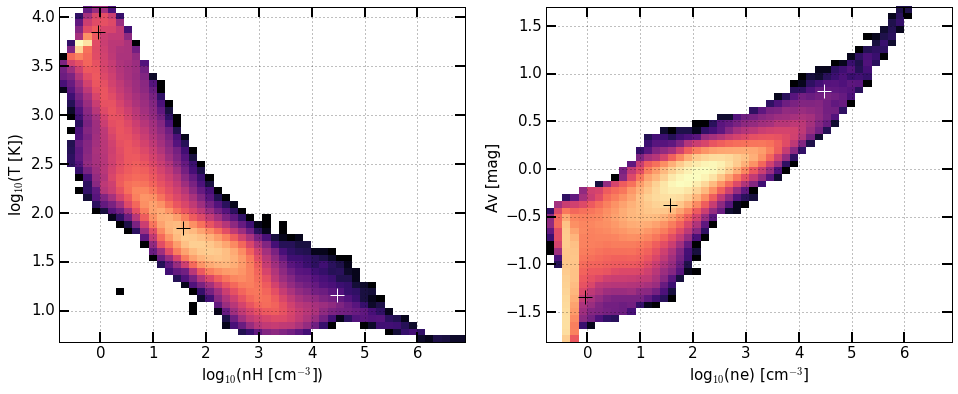

In [19]:
# This is basically the distribution of cells in the simulation dedicated to density and temperature.

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)

ax.hist2d(np.log10(box["nH"]), np.log10(box["temp"]), bins=50, norm=LogNorm(), normed=True, cmap="magma")

ax.scatter(np.log10(0.9), np.log10(7.0e3), s=200, c="k",  marker="+")
ax.scatter(np.log10(36), np.log10(7.0e1), s=200, c="k",  marker="+")
ax.scatter(np.log10(3e4), np.log10(14.4), s=200, c="w",  marker="+")

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_xlabel("log$_{10}$(nH [cm$^{-3}$])", fontsize=15)
ax.set_ylabel("log$_{10}$(T [K])", fontsize=15)

#ax.set_ylim(0,1)

ax.grid("on")

ax = fig.add_subplot(122)

#ax.hist2d(np.log10(box["xe"]), np.log10(box["cdto"]), bins=50, norm=LogNorm(), normed=True, cmap="magma", range=([[np.log10(min_xe), np.log10(max_xe)],[np.log10(min_Av), np.log10(50.0)]]))
ax.hist2d(np.log10(box["nH"]), np.log10(box["cdto"]), bins=50, norm=LogNorm(), normed=True, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_Av), np.log10(50.0)]]))
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.scatter(np.log10(0.9), np.log10(0.046), s=200, c="k",  marker="+")
ax.scatter(np.log10(36), np.log10(0.42), s=200, c="k",  marker="+")
ax.scatter(np.log10(3e4), np.log10(6.603), s=200, c="w",  marker="+")

ax.set_xlabel("log$_{10}$(ne) [cm$^{-3}$]", fontsize=15)
ax.set_ylabel("Av [mag] ", fontsize=15)

ax.grid("on")


fig.show()

G0 = 1.7

G = np.zeros_like(box["cdto"])
pp = 0
for ii in range(len(G)):
    prog = ii*100. / len(G)
    if prog >= 25*(1+pp):
        print("progress %.2i "%(25*(1+pp)))
        pp +=1

    G[ii] = fz.get_G(box["cdto"][ii], G0)

In [20]:
import pickle
outfile = open('/home/jcibanezm/codes/DustAnalysis/Charge/PaperFigures_DustCharge/new_xe.pkl', 'rb')
new_xe = pickle.load(outfile)
#pickle.dump(xe_new1000, outfile)
outfile.close()

In [21]:
new_xe = np.zeros_like(box["nH"])
new_ne = np.zeros_like(box["nH"])
Ntot = box["cdto"]*1.87e21

for i in range(len(new_xe)):
#for i in range(10):
    #print(i)
    NH2 = fz.get_NH2(box["cdh2"][i], box["temp"][i])
    zeta = fz.get_zeta(NH2)
    #zeta = fz.get_zeta(Ntot[i])
    new_ne[i], new_xe[i] = fz.compute_new_xe([box["nH"][i], box["nC"][i]], [box["xHp"][i], box["xCp"][i]], box["xH2"][i], zeta) 

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  % accuracy, RuntimeWarning)


In [23]:
print("Done")

Done


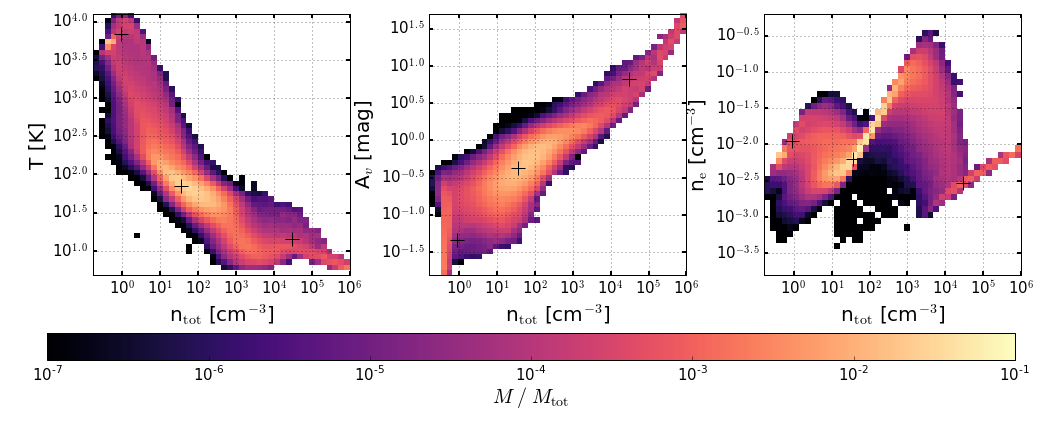

In [42]:
xsize = 14
ysize = 5.5

nfigs_x = 3
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.335
wpad = 0.072
w0   = 0.065

xs_panel = 0.765 / nfigs_x 
ys_panel = 0.66 / nfigs_y 

# Formatting tick labels in log scale.
def format_func(value, tick_number):
    return "10$^{%.1f}$"%value

# Formatting tick labels in log scale.
def format_func2(value, tick_number):
    return "10$^{%i}$"%value

############################################################################################################
############################               5 Angstroms             #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "title?", fontsize=20, horizontalalignment='center')

plt.axis('off')

total_mass = np.sum(box["cell_mass"])

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0


ax = fig.add_axes([w0 + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

#H, xc, yc = np.histogram2d(np.log10(box["nH"]), np.log10(box["temp"]), weights=box["cell_mass"].in_units("Msun"), bins=50)
#H_norm = H / np.sum(box["cell_mass"].in_units("Msun").value)

cax = ax.hist2d(np.log10(box["nH"]), np.log10(box["temp"]), weights=box["cell_mass"]/total_mass, bins=50, norm=LogNorm(), cmap="magma", vmin=1.0e-7, vmax=0.1)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=18, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=18, direction="in")
ax.grid("on")

ax.scatter(np.log10(0.9), np.log10(7.0e3), s=200, c="k",  marker="+")
ax.scatter(np.log10(36), np.log10(7.0e1), s=200, c="k",  marker="+")
ax.scatter(np.log10(3e4), np.log10(14.4), s=200, c="k",  marker="+")

ax.set_ylabel("T [K]", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{tot}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.set_xlim(np.min(np.log10(box["nH"])), 6.0)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(box["nH"]), np.log10(box["cdto"]), bins=50, norm=LogNorm(),weights=box["cell_mass"]/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_Av), np.log10(50.0)]]), vmin=1.0e-7, vmax=0.1)
#ax.hist2d(np.log10(box["nH"]), G, bins=50, norm=LogNorm(), normed=True, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.min(G), np.max(G)]]))

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.scatter(np.log10(0.9), np.log10(0.046), s=200, c="k",  marker="+")
ax.scatter(np.log10(36), np.log10(0.42), s=200, c="k",  marker="+")
ax.scatter(np.log10(3e4), np.log10(6.603), s=200, c="k",  marker="+")

ax.grid("on")

ax.set_ylabel("A$_{v}$ [mag]", fontsize=20)
#ax.set_ylabel("G", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{tot}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.set_xlim(np.min(np.log10(box["nH"])), 6.0)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad+0.005, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(box["nH"]), np.log10(new_ne), bins=50, norm=LogNorm(), weights=box["cell_mass"]/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_ne), np.log10(max_ne)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.scatter(np.log10(0.9), np.log10(0.011), s=200, c="k",  marker="+")
ax.scatter(np.log10(36), np.log10(0.0063), s=200, c="k",  marker="+")
ax.scatter(np.log10(3e4), np.log10(0.00296637), s=200, c="k",  marker="+")

ax.grid("on")

ax.set_xlabel("n$_{\\mathrm{tot}}$ [cm$^{-3}$]", fontsize=20)
ax.set_ylabel("n$_{\\mathrm{e}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.set_ylim(-3.8, -0.2)
ax.set_xlim(np.min(np.log10(box["nH"])), 6.0)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Add colorbar.

#cax[3] = cax[3]/np.sum(box["cell_mass"].in_units("Msun").value)

cbar_ax = fig.add_axes([0.02, 0.12, 0.96, 0.07])
cbar    = fig.colorbar(cax[3], cax=cbar_ax, orientation="horizontal")
#cbar    = fig.colorbar(cax, cax=cbar_ax, orientation="horizontal")

cbar.set_label("$M\;/\;M_{\mathrm{tot}}$", fontsize=20, labelpad=1)
cbar.ax.tick_params(labelsize=15)

fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Figure_2_CF_phasePlots.pdf", format="pdf")